In [142]:
import numpy as np
import pandas as pd

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# look at all categories
!ls -lah data/

total 266M
drwxrwxr-x 2 vtrokhymenko vtrokhymenko 4.0K Jan 16 12:03 .
drwxrwxr-x 5 vtrokhymenko vtrokhymenko 4.0K Jan 17 01:09 ..
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20

### load data

In [3]:
%%time
df = pd.read_csv('data/sport.csv.bz2')
print(df.shape)

(60849, 7)
CPU times: user 4.23 s, sys: 95.4 ms, total: 4.32 s
Wall time: 4.32 s


In [4]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,"Лейла Али, дочь известного боксера-тяжеловеса ...",Спорт
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",В субботу 9 октября на Большой спортивной арен...,Спорт


## preprocess

* ### get dates

In [5]:
r = re.compile('(\d{4})/(\d{2})/(\d{2})')
r.findall('https://lenta.ru/news/1999/10/08/boxing/')

<>:1: DeprecationWarning: invalid escape sequence \d


[('1999', '10', '08')]

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 187 ms, sys: 7.88 ms, total: 195 ms
Wall time: 194 ms


* ### clean text

In [7]:
import preprocessing_tools as pr

/home/vtrokhymenko/proj_news_viz/proj_news_viz/nlp/topic_models/separateTopics/preprocessing_tools.py:29: DeprecationWarning: invalid escape sequence \s
  text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))


In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 6.85 s, sys: 39.2 ms, total: 6.89 s
Wall time: 6.89 s


In [10]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10


* ### cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 1min 11s, sys: 12.7 ms, total: 1min 11s
Wall time: 1min 11s


In [12]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10


* ### lemmatization

In [13]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 1min 37s, sys: 53.3 ms, total: 1min 38s
Wall time: 1min 38s


In [14]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month,lemmatized_text
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10,"[лейла, али, дочь, известный, боксератяжеловес..."
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10,"[суббота, октябрь, большой, спортивный, арен, ..."


* ### docID
for future when will be doing join topic matrix with documents

In [15]:
df['docID'] = list(range(df.shape[0]))

In [16]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month,lemmatized_text,docID
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10,"[лейла, али, дочь, известный, боксератяжеловес...",0
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10,"[суббота, октябрь, большой, спортивный, арен, ...",1


In [17]:
df.year.min()

1999

## bigartm

* ### prepare

In [108]:
%%time

vwpath = 'data/sport_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} |default {}\n'.format(did, ' '.join(text)))

CPU times: user 578 ms, sys: 56.1 ms, total: 634 ms
Wall time: 608 ms


In [109]:
id_date = df[['docID', 'year', 'month']].copy()

collect batchs and collect the dictionary

In [20]:
%%time

batches_path = 'data/batches'

batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

CPU times: user 18.8 s, sys: 423 ms, total: 19.2 s
Wall time: 2.96 s


In [197]:
batch_vectorizer

artm.BatchVectorizer(data_path="data/batches", num_batches=61)

In [21]:
%%time

dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

CPU times: user 1.36 s, sys: 20 ms, total: 1.38 s
Wall time: 1.38 s


In [ ]:
dictionary.save_text('cor_dict.txt')

In [110]:
dictionary.filter(min_df=10, max_dictionary_size=int(4.5e5))

artm.Dictionary(name=79b6be88-3507-4d53-94ef-078021f4e285, num_entries=19668)

* ### build model

In [203]:
num_topics = 50
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

### add scores

In [204]:
# default
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
#model.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=num_topics))

In [205]:
# hand-made

#https://github.com/bigartm/bigartm/blob/master/docs/tutorials/python_userguide/coherence.txt
    
cooc_dict = artm.Dictionary()

cooc_dict.gather(data_path='batches_folder',
                 cooc_file_path='cooc.txt',
                 vocab_file_path='vocab.txt',
                 symmetric_cooc_values=True)

coherence_score = artm.TopTokensScore(name='TopTokensCoherenceScore',
                                      class_id='@default_class', 
                                      topic_names=[u'topic_0',u'topic_1'],
                                      dictionary=cooc_dict,
                                      num_tokens=num_topics)

model.scores.add(coherence_score)

### add regularizers

In [206]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [207]:
%%time

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 2min 11s, sys: 0 ns, total: 2min 11s
Wall time: 9.41 s


In [ ]:
#model.save('')

In [220]:
model.score_tracker['TopTokensCoherenceScore'].average_coherence

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [209]:
model.score_tracker['SparsityThetaScore'].last_value

0.8554086089134216

In [210]:
model.score_tracker['PerplexityScore'].last_value

852.5618896484375

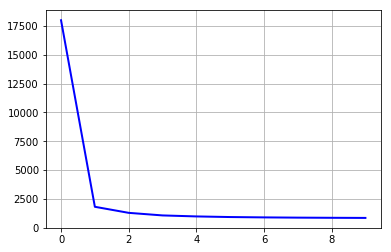

In [211]:
plt.plot(range(model.num_phi_updates),
         model.score_tracker['PerplexityScore'].value, 'b-',
         linewidth=2)
plt.grid()

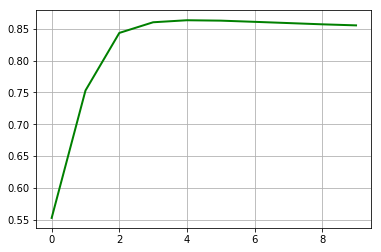

In [212]:
plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityThetaScore'].value, 'g-',
         linewidth=2)
plt.grid()

In [74]:
saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens
for topic_name in model.topic_names:
    print(saved_top_tokens[topic_name])

KeyError: 'top_tokens_score'

In [217]:
for topic_name in model.topic_names:
    print(f'{topic_name}:')
    print(f'{model.score_tracker['TopTokensScore'].last_tokens[topic_name]}')

SyntaxError: invalid syntax (<ipython-input-217-77b08f1c70ca>, line 3)

In [219]:
model.score_tracker['TopTokensScore'].last_tokens

{}

In [ ]:
model

In [32]:
phi = model.get_phi()
phi['word'] = phi.index
phi.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,word
кампаньоть,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,кампаньоть
сяося,0.0,0.0,0.0,0.0,0.000058,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,сяося
хаазе,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,хаазе
ambro,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ambro
предсезонка,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,предсезонка


In [33]:
for col in phi.columns:
    if col != 'word':
        print(col)
        print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])


topic_0
	 ['болельщик' 'фанат' 'который' 'время' 'полиция' 'человек' 'стадион' 'это'
 'инцидент' 'клуб']
topic_1
	 ['это' 'слово' 'заявить' 'сказать' 'рассказать' 'мочь' 'свой' 'отметить'
 'хотеть' 'который']
topic_2
	 ['больница' 'время' 'врач' 'летний' 'произойти' 'смерть' 'автомобиль'
 'находиться' 'помощь' 'машина']
topic_3
	 ['бразилия' 'аргентина' 'мир' 'рейтинг' 'место' 'бразильский' 'бразилец'
 'футбол' 'сборная' 'мексика']
topic_4
	 ['биатлонист' 'россия' 'килограмм' 'мир' 'спортсмен' 'соревнование'
 'чемпионат' 'союз' 'сбр' 'категория']
topic_5
	 ['миллион' 'доллар' 'компания' 'клуб' 'фунт' 'тысяча' 'владелец' 'акция'
 'сумма' 'финансовый']
topic_6
	 ['кхл' 'хоккейный' 'клуб' 'металлург' 'ска' 'авангард' 'лига' 'хоккеист'
 'динамо' 'барс']
topic_7
	 ['бой' 'поединок' 'кличко' 'боксёр' 'чемпион' 'боксёрский' 'мир' 'титул'
 'версия' 'украинец']
topic_8
	 ['арбитр' 'карточка' 'игрок' 'франция' 'защитник' 'дисквалификация'
 'судья' 'дисквалифицировать' 'футболист' 'нападать']
top

---

In [139]:
%%time
step, perplexity, sparseTheta = [], [], []

for i in range(10,100,10):
    print(f'{i} .........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    
    sparseTheta.append(model.score_tracker['SparsityThetaScore'].last_value)
    perplexity.append(model.score_tracker['PerplexityScore'].last_value)
    print(f'\tSparsityThetaScore: {SparsityThetaScore}')
    print(f'\tPerplexityScore: {PerplexityScore}')
    print('\ttime:',time.now()-date_start)

10 .........
	time:  0:01:01.926256
20 .........
	time:  0:01:11.502151
30 .........
	time:  0:01:21.609889
40 .........
	time:  0:01:30.651409
50 .........
	time:  0:01:39.922096
60 .........
	time:  0:01:48.397480
70 .........
	time:  0:01:52.436788
80 .........
	time:  0:02:00.984747
90 .........
	time:  0:02:10.510832
CPU times: user 2h 1min 10s, sys: 0 ns, total: 2h 1min 10s
Wall time: 14min 37s


Text(0.5, 1.0, 'PerplexityScore')

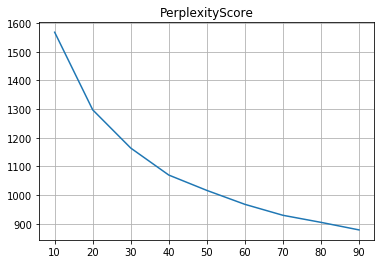

In [140]:
plt.plot(step, perplexity)

ax = plt.gca()
ax.set_xticks(step)

plt.grid()
plt.title('PerplexityScore')

Text(0.5, 1.0, 'SparsityThetaScore')

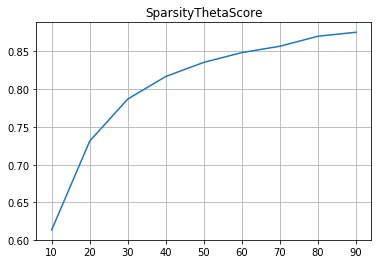

In [141]:
plt.plot(step, sparseTheta)

ax = plt.gca()
ax.set_xticks(step)

plt.grid()
plt.title('SparsityThetaScore')

In [142]:
phi = model.get_phi()
phi['word'] = phi.index

for col in phi.columns:
    if col != 'word':
        print(col)
        print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0
	 ['турецкий' 'турция' 'самолёт' 'аэропорт' 'автобус' 'отель' 'прибыть'
 'фенербахча' 'гостиница' 'прилететь']
topic_1
	 ['журналист' 'информация' 'опровергнуть' 'сми' 'вопрос' 'появиться'
 'интервью' 'ответить' 'слух' 'гражданство']
topic_2
	 ['больница' 'врач' 'смерть' 'скончаться' 'помощь' 'время' 'состояние'
 'умереть' 'находиться' 'летний']
topic_3
	 ['бразилия' 'бразильский' 'бразилец' 'роналдиньо' 'америка' 'сантос'
 'пеле' 'парагвай' 'санпаула' 'фламенго']
topic_4
	 ['мир' 'чемпионат' 'россия' 'турнир' 'первенство' 'пройти' 'участие'
 'мировой' 'сообщать' 'чемпион']
topic_5
	 ['миллион' 'доллар' 'тысяча' 'сумма' 'евро' 'фунт' 'деньга' 'зарплата'
 'рубль' 'получить']
topic_6
	 ['кхл' 'хоккейный' 'ска' 'авангард' 'металлург' 'ак' 'барс' 'хоккеист'
 'динамо' 'салават']
topic_7
	 ['бой' 'чемпион' 'поединок' 'кличко' 'боксёр' 'титул' 'год' 'боксёрский'
 'мир' 'версия']
topic_8
	 ['карточка' 'жёлтый' 'португалия' 'красный' 'порту' 'португальский'
 'португалец' 'греция' 'хорва

	 ['украина' 'украинский' 'шахтёр' 'киевский' 'донецкий' 'киев' 'украинец'
 'днепр' 'ффу' 'киевлянин']
topic_77
	 ['медаль' 'завоевать' 'золотой' 'бронзовый' 'серебряный' 'олимпиада'
 'олимпийский' 'призёр' 'выиграть' 'игра']
topic_78
	 ['телеканал' 'трансляция' 'канал' 'эфир' 'прямой' 'комментатор' 'вести'
 'тв' 'руни' 'нтв']
topic_79
	 ['болельщик' 'фанат' 'стадион' 'футбольный' 'человек' 'время' 'полиция'
 'трибуна' 'беспорядок' 'задержать']
topic_80
	 ['локомотив' 'крыло' 'московский' 'совет' 'ростов' 'москва' 'динамо'
 'сатурн' 'торпедо' 'спартак']
topic_81
	 ['манчестер' 'англия' 'английский' 'юнайтед' 'сити' 'ливерпуль' 'мю'
 'тоттенхэма' 'премьерлига' 'англичанин']
topic_82
	 ['twitter' 'написать' 'страница' 'аккаунт' 'instagram' 'белорусский'
 'опубликовать' 'фотография' 'белоруссия' 'пользователь']
topic_83
	 ['южный' 'корея' 'япония' 'японский' 'кндр' 'узбекистан' 'корейский'
 'кореец' 'оаэ' 'ривалдый']
topic_84
	 ['место' 'занять' 'рейтинг' 'третье' 'занимать' 'первое' 'поз

## with n-grams

* ### 2-grams

In [38]:
# create 2-grams

text = df.text
tokenized_train = [t.split() for t in text]

phrases = Phrases(tokenized_train)
bigram = Phraser(phrases)

In [41]:
sent = df.text[10].split()
print(bigram[sent])

['на', 'завершившемся', 'в', 'японии', 'чемпионате_мира', 'формулы', 'пилот_mclaren', 'мика_хаккинен', 'сохранил_титул', 'чемпиона', 'гонщики', 'ferrari_михаэль_шумахер', 'и', 'эдди_ирвайн', 'заняли_второе', 'и', 'третье_места', 'зато', 'болиды', 'ferrari', 'оказались', 'лучшими', 'в', 'нынешнем_сезоне', 'автогонокформулы', 'завоевав', 'первое_место', 'по_итогам', 'чемпионата_мира', 'в', 'категории', 'конструкторов', 'как_передает', 'итартасс', 'инженеры', 'ferrariнабрали', 'очков', 'после', 'заключительного_этапа', 'состязаний', 'в', 'японской', 'судзуке', 'опередив', 'конкурентов', 'из', 'mclaren', 'на', 'четыре_очка', 'знаменитая', 'марка', 'вернула_себе', 'высший', 'титул', 'после', 'летнего_перерыва', 'последний_раз', 'в', 'данной', 'категории', 'команда', 'ferrari', 'была', 'лучшей', 'в', 'году', 'как', 'считают', 'спортивные', 'обозреватели', 'победа', 'хаккинена', 'была', 'предопределена', 'уже', 'с', 'самого_старта', 'когда', 'он', 'вырвался_вперед', 'опередив', 'шумахера', 'п

In [43]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month,lemmatized_text,docID
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10,"[лейла, али, дочь, известный, боксератяжеловес...",0
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10,"[суббота, октябрь, большой, спортивный, арен, ...",1


### lemmatization

In [46]:
%%time
df['lemmatized_text_2gram'] = df.text.apply(lambda x: pr.lemmatization(x.split()))

CPU times: user 6min 11s, sys: 12.2 s, total: 6min 24s
Wall time: 5min 43s


In [47]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month,lemmatized_text,docID,lemmatized_text_2gram
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10,"[лейла, али, дочь, известный, боксератяжеловес...",0,"[лейла, али, дочь, известный, боксератяжеловес..."
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10,"[суббота, октябрь, большой, спортивный, арен, ...",1,"[суббота, октябрь, большой, спортивный, арен, ..."


### bigartm

In [48]:
%%time

vwpath = 'data/sport_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text_2gram', 'docID']].values:
        fp.write('{} |default {}\n'.format(did, ' '.join(text)))

CPU times: user 512 ms, sys: 127 ms, total: 639 ms
Wall time: 611 ms


In [ ]:
id_date = df[['docID', 'year', 'month']].copy()

collect batchs and collect the dictionary

In [49]:
%%time

batches_path = 'data/batches'

batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

CPU times: user 19.8 s, sys: 610 ms, total: 20.4 s
Wall time: 3.32 s


In [50]:
%%time

dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

CPU times: user 1.81 s, sys: 84.4 ms, total: 1.9 s
Wall time: 1.72 s


* ### build model

In [51]:
num_topics = 50
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)

### add scores

In [52]:
# default
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
#model.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

### add regularizers

In [54]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [55]:
%%time

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 2min 40s, sys: 538 ms, total: 2min 41s
Wall time: 19.8 s


In [57]:
model.score_tracker['SparsityThetaScore'].last_value

0.8539995551109314

In [58]:
model.score_tracker['PerplexityScore'].last_value

1066.50341796875

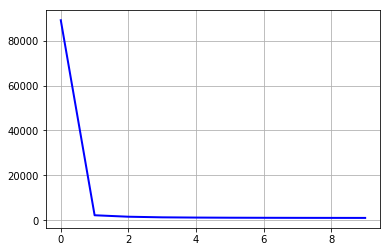

In [59]:
plt.plot(range(model.num_phi_updates),
         model.score_tracker['PerplexityScore'].value, 'b-',
         linewidth=2)
plt.grid()

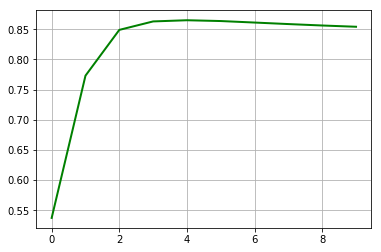

In [60]:
plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityThetaScore'].value, 'g-',
         linewidth=2)
plt.grid()

In [63]:
phi = model.get_phi()
phi['word'] = phi.index
phi.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,word
кампаньоть,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,кампаньоть
сяося,0.0,0.0,0.0,0.0,0.000058,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,сяося
ambro,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ambro
предсезонка,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,предсезонка
кирхайзный,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,кирхайзный


In [64]:
for col in phi.columns:
    if col != 'word':
        print(col)
        print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])


topic_0
	 ['болельщик' 'фанат' 'который' 'время' 'полиция' 'человек' 'стадион' 'это'
 'инцидент' 'произойти']
topic_1
	 ['это' 'слово' 'заявить' 'сказать' 'рассказать' 'мочь' 'свой' 'отметить'
 'хотеть' 'который']
topic_2
	 ['больница' 'время' 'врач' 'летний' 'произойти' 'смерть' 'автомобиль'
 'находиться' 'помощь' 'машина']
topic_3
	 ['бразилия' 'аргентина' 'мир' 'рейтинг' 'место' 'бразильский' 'бразилец'
 'футбол' 'сборная' 'мексика']
topic_4
	 ['биатлонист' 'россия' 'килограмм' 'мир' 'спортсмен' 'соревнование'
 'чемпионат' 'союз' 'сбр' 'категория']
topic_5
	 ['миллион' 'доллар' 'компания' 'клуб' 'фунт' 'тысяча' 'владелец' 'акция'
 'сумма' 'финансовый']
topic_6
	 ['кхл' 'хоккейный' 'клуб' 'металлург' 'ска' 'авангард' 'лига' 'хоккеист'
 'динамо' 'барс']
topic_7
	 ['бой' 'поединок' 'кличко' 'боксёр' 'чемпион' 'боксёрский' 'мир' 'титул'
 'версия' 'украинец']
topic_8
	 ['арбитр' 'карточка' 'игрок' 'франция' 'защитник' 'дисквалификация'
 'судья' 'дисквалифицировать' 'футболист' 'нападать'

* ### 3-grams

In [65]:
tg_phrases = Phrases(bigram[tokenized_train])
trigram = Phraser(tg_phrases)

In [66]:
sent = df.text[10].split()
print(trigram[sent])

['на', 'завершившемся', 'в', 'японии', 'чемпионате_мира', 'формулы', 'пилот_mclaren', 'мика_хаккинен', 'сохранил_титул', 'чемпиона', 'гонщики', 'ferrari_михаэль_шумахер', 'и', 'эдди_ирвайн', 'заняли_второе', 'и', 'третье_места', 'зато', 'болиды', 'ferrari', 'оказались', 'лучшими', 'в', 'нынешнем_сезоне', 'автогонокформулы', 'завоевав', 'первое_место', 'по_итогам', 'чемпионата_мира', 'в', 'категории', 'конструкторов', 'как_передает', 'итартасс', 'инженеры', 'ferrariнабрали', 'очков_после', 'заключительного_этапа', 'состязаний', 'в', 'японской', 'судзуке', 'опередив', 'конкурентов', 'из', 'mclaren', 'на', 'четыре_очка', 'знаменитая', 'марка', 'вернула_себе', 'высший', 'титул', 'после', 'летнего_перерыва', 'последний_раз', 'в', 'данной', 'категории', 'команда', 'ferrari', 'была', 'лучшей', 'в', 'году', 'как_считают', 'спортивные', 'обозреватели', 'победа', 'хаккинена', 'была', 'предопределена', 'уже', 'с', 'самого_старта', 'когда', 'он', 'вырвался_вперед', 'опередив', 'шумахера', 'по', 'к

### lemmatization

In [67]:
%%time
df['lemmatized_text_3gram'] = df.text.apply(lambda x: pr.lemmatization(x.split()))

CPU times: user 6min 23s, sys: 11.5 s, total: 6min 34s
Wall time: 5min 54s


In [68]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month,lemmatized_text,docID,lemmatized_text_2gram,lemmatized_text_3gram
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10,"[лейла, али, дочь, известный, боксератяжеловес...",0,"[лейла, али, дочь, известный, боксератяжеловес...","[лейла, али, дочь, известный, боксератяжеловес..."
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10,"[суббота, октябрь, большой, спортивный, арен, ...",1,"[суббота, октябрь, большой, спортивный, арен, ...","[суббота, октябрь, большой, спортивный, арен, ..."


### bigartm

In [69]:
%%time

vwpath = 'data/sport_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text_2gram', 'docID']].values:
        fp.write('{} |default {}\n'.format(did, ' '.join(text)))

CPU times: user 563 ms, sys: 94.9 ms, total: 658 ms
Wall time: 616 ms


In [97]:
id_date = df[['docID', 'year', 'month']].copy()

collect batchs and collect the dictionary

In [70]:
%%time

batches_path = 'data/batches'

batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

CPU times: user 19.8 s, sys: 159 ms, total: 19.9 s
Wall time: 3.33 s


In [71]:
%%time

dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

CPU times: user 2.01 s, sys: 91.2 ms, total: 2.1 s
Wall time: 1.82 s


* ### build model

In [72]:
num_topics = 50
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)

### add scores

In [73]:
# default
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
#model.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

### add regularizers

In [74]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [75]:
%%time

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 2min 40s, sys: 493 ms, total: 2min 41s
Wall time: 19.8 s


In [76]:
model.score_tracker['SparsityThetaScore'].last_value

0.8539995551109314

In [77]:
model.score_tracker['PerplexityScore'].last_value

1066.50341796875

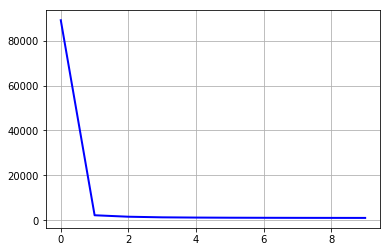

In [78]:
plt.plot(range(model.num_phi_updates),
         model.score_tracker['PerplexityScore'].value, 'b-',
         linewidth=2)
plt.grid()

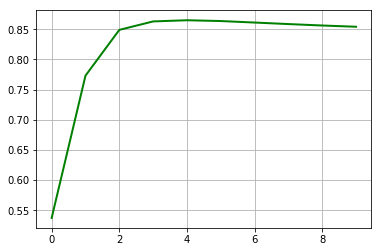

In [79]:
plt.plot(range(model.num_phi_updates),
         model.score_tracker['SparsityThetaScore'].value, 'g-',
         linewidth=2)
plt.grid()

In [80]:
phi = model.get_phi()
phi['word'] = phi.index
phi.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,word
кампаньоть,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,кампаньоть
сяося,0.0,0.0,0.0,0.0,0.000058,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,сяося
ambro,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ambro
предсезонка,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,предсезонка
кирхайзный,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,кирхайзный


In [81]:
for col in phi.columns:
    if col != 'word':
        print(col)
        print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])


topic_0
	 ['болельщик' 'фанат' 'который' 'время' 'полиция' 'человек' 'стадион' 'это'
 'инцидент' 'произойти']
topic_1
	 ['это' 'слово' 'заявить' 'сказать' 'рассказать' 'мочь' 'свой' 'отметить'
 'хотеть' 'который']
topic_2
	 ['больница' 'время' 'врач' 'летний' 'произойти' 'смерть' 'автомобиль'
 'находиться' 'помощь' 'машина']
topic_3
	 ['бразилия' 'аргентина' 'мир' 'рейтинг' 'место' 'бразильский' 'бразилец'
 'футбол' 'сборная' 'мексика']
topic_4
	 ['биатлонист' 'россия' 'килограмм' 'мир' 'спортсмен' 'соревнование'
 'чемпионат' 'союз' 'сбр' 'категория']
topic_5
	 ['миллион' 'доллар' 'компания' 'клуб' 'фунт' 'тысяча' 'владелец' 'акция'
 'сумма' 'финансовый']
topic_6
	 ['кхл' 'хоккейный' 'клуб' 'металлург' 'ска' 'авангард' 'лига' 'хоккеист'
 'динамо' 'барс']
topic_7
	 ['бой' 'поединок' 'кличко' 'боксёр' 'чемпион' 'боксёрский' 'мир' 'титул'
 'версия' 'украинец']
topic_8
	 ['арбитр' 'карточка' 'игрок' 'франция' 'защитник' 'дисквалификация'
 'судья' 'дисквалифицировать' 'футболист' 'нападать'

## Get topics-docs matrix
### Sparse

In [83]:
theta = model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
theta[0].shape

(50, 60840)

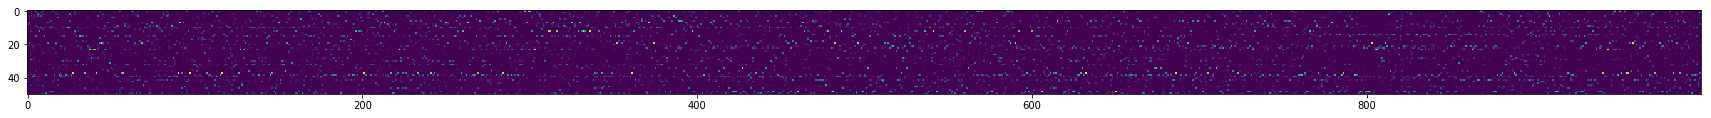

In [91]:
plt.figure(figsize=(30, 20))
plt.imshow(theta[0][:, 2000:3000].toarray());

## Dense theta matrix¶

In [95]:
theta = model.transform(batch_vectorizer=batch_vectorizer)

theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
24000,0.0,0.102511,0.0,0.032461,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.05962,0.000000,0.043917,0.000000,0.074348
24001,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.148562,0.0,0.0,0.0,0.0,0.00000,0.459173,0.000000,0.000000,0.047601
24002,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.021898,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.032761
24003,0.0,0.000000,0.0,0.195298,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
24004,0.0,0.000000,0.0,0.000000,0.0,0.0,0.326388,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.006954,0.000000


In [98]:
id_date.head()

,docID,year,month
0,0,1999,10
1,1,1999,10
2,2,1999,10
3,3,1999,10
4,4,1999,12


## DataViz
### Prepare Theta matrix

In [99]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,0,1999,10,0.000000,0.194916,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.01791,0.000000,0.041716,0.0
1,1,1999,10,0.057561,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.0,0.082272,0.00000,0.033301,0.000000,0.0
2,2,1999,10,0.212302,0.049977,0.000000,0.014105,0.0,0.234681,0.0,...,0.0,0.034694,0.08097,0.000000,0.0,0.004409,0.00000,0.029743,0.000000,0.0
3,3,1999,10,0.000000,0.013450,0.033773,0.000000,0.0,0.000000,0.0,...,0.0,0.028709,0.00000,0.026098,0.0,0.024375,0.00000,0.000000,0.000000,0.0
4,4,1999,12,0.000000,0.000000,0.000000,0.000000,0.0,0.187523,0.0,...,0.0,0.000000,0.00000,0.000000,0.0,0.222109,0.00000,0.000000,0.000000,0.0


In [102]:
topics = ['topic_{}'.format(i) for i in range(num_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
gb.shape

(227, 50)

In [103]:
gb.head()

topic_0   topic_1   topic_2   topic_3  topic_4   topic_5  \
year month                                                              
1999 9      0.998137  0.112835  0.156687  0.076535  0.00000  0.358059   
     10     0.269863  0.258343  0.033773  0.014105  0.00000  0.234681   
     11     0.266029  0.000000  0.088378  0.000000  0.04653  0.043470   
     12     0.000000  0.000000  0.000000  0.000000  0.00000  0.187523   
2000 1      1.169601  0.329489  0.143173  0.000000  0.00000  0.000000   

             topic_6   topic_7  topic_8   topic_9    ...     topic_40  \
year month                                           ...                
1999 9      0.039460  0.000000      0.0  0.079641    ...     0.019393   
     10     0.000000  0.206786      0.0  0.000000    ...     0.000000   
     11     0.000000  0.110370      0.0  0.000000    ...     0.271505   
     12     0.000000  0.185079      0.0  0.090674    ...     0.000000   
2000 1      0.008875  0.000000      0.0  0.015842    ...     0.000000   

            topic_41  topic_42  topic_43  topic_44  topic_45  topic_46  \
year month                                                               
1999 9      0.000000  0.000000  0.042144  0.039351  0.394900  0.000000   
     10     0.063403  0.080970  0.026098  0.000000  0.111057  0.017910   
     11     0.000000  0.000000  0.000000  0.006558  0.069231  0.020433   
     12     0.022315  0.000000  0.010638  0.216428  0.222109  0.000000   
2000 1      0.000000  0.252661  0.117744  0.000000  0.401670  0.052477   

            topic_47  topic_48  topic_49  
year month                                
1999 9      0.135376  0.000000  0.000000  
     10     0.063044  0.041716  0.000000  
     11     0.296241  0.038930  0.013186  
     12     0.000000  0.000000  0.000000  
2000 1      0.187288  0.000000  0.109549  

[5 rows x 50 columns]

### Straightforward matrix heatmap

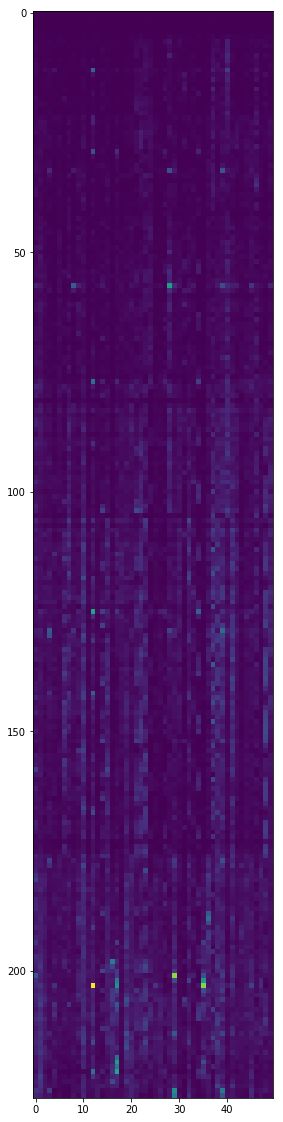

In [104]:
plt.figure(figsize=(10, 20))
plt.imshow(gb[topics])

### PyGal

In [105]:
import pygal
from IPython.display import SVG, HTML

In [106]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [107]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)

HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

---

## add regularizers step by step

In [138]:
data = df.copy()

In [175]:
name_df = 'sport'

In [139]:
data.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month,lemmatized_text,docID,lemmatized_text_2gram,lemmatized_text_3gram
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10,"[лейла, али, дочь, известный, боксератяжеловес...",0,"[лейла, али, дочь, известный, боксератяжеловес...","[лейла, али, дочь, известный, боксератяжеловес..."
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10,"[суббота, октябрь, большой, спортивный, арен, ...",1,"[суббота, октябрь, большой, спортивный, арен, ...","[суббота, октябрь, большой, спортивный, арен, ..."


In [179]:
def split_dataset(data):
    corpus = data[['lemmatized_text', 'docID']].copy()
    train, dev = train_test_split(corpus, test_size=0.2, random_state=0)
    return train.reset_index(drop=True), dev.reset_index(drop=True)

In [180]:
X_train, X_dev = split_dataset(data)
X_train.shape, X_dev.shape

((48679, 2), (12170, 2))

In [181]:
def to_vw_format(data, name: str):
    with open(f'processed_data/{name}.vw', 'w') as vw_corpus:
        for text, doc_id in X_train.values:
            #tokens = literal_eval(text) # uncomment this if u use dataset from read_csv
            tokens = text
            doc = ' '.join(tokens)
            vw_corpus.write(f'{doc_id} | {doc}\n')
    return True

In [185]:
to_vw_format(X_train, f'{name_df}_train')
to_vw_format(X_train, f'{name_df}_dev')

True

collect batchs and collect the dictionary

In [183]:
def init_batch_vectorizer(vwpath, batches_path, gather=False):
    batch_vect = artm.BatchVectorizer(data_path=vwpath, 
                                      data_format='vowpal_wabbit', 
                                      target_folder=batches_path, 
                                      gather_dictionary=gather, 
                                      batch_size=10000)
    return batch_vect

In [186]:
batch_train = init_batch_vectorizer(f'processed_data/{name_df}_train.vw', 'processed_data/batches_train')
batch_dev = init_batch_vectorizer(f'processed_data/{name_df}_dev.vw', 'processed_data/batches_dev')


In [187]:
corpus_dictionary = artm.Dictionary('corpus_dictionary')
corpus_dictionary.gather('processed_data/batches_train')

In [188]:
corpus_dictionary.save_text('processed_data/cor_dict.txt')

In [189]:
corpus_dictionary.filter(min_df=10, max_dictionary_size=int(4.5e5))

artm.Dictionary(name=corpus_dictionary, num_entries=17545)

In [190]:
corpus_dictionary.save_text('processed_data/cor_dict_filtered.txt')

* ### build model

In [191]:
num_topics = 50
model = artm.ARTM(num_topics=num_topics, num_processors=6, show_progress_bars=True, seed=1)

### add scores

In [192]:
model.scores.add(artm.PerplexityScore('perplexity_score', dictionary=corpus_dictionary))
model.scores.add(artm.SparsityThetaScore('sparse_theta_score'))
model.scores.add(artm.SparsityPhiScore('sparse_phi_score'))

### add regularizers

In [193]:
#model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
#model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', tau=2.5e5))

In [194]:
model.initialize(dictionary)

In [198]:
for i in range(1, 20):
    print(f'{i} .........')
    date_start = time.now()
    
    if i == 4:
        model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth_sparse_phi_regularizer', tau=-0.55)) 
        print('added smooth sparse phi')
    if i == 8:
        model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='smooth_sparse_theta_regularizer', tau=-0.75))
        print('added smooth sparse theta')
    
    model.fit_offline(batch_vectorizer=batch_train, num_collection_passes=10)
    train_perplexity = model.score_tracker['perplexity_score'].last_value
    train_theta_sparsity = model.score_tracker['sparse_theta_score'].last_value
    train_theta_sparsity = round(train_theta_sparsity, 4)
    train_phi_sparsity = model.score_tracker['sparse_phi_score'].last_value
    train_phi_sparsity = round(train_phi_sparsity, 4)
    print(f'iteration: {i}, train perplexity: {train_perplexity}')
    print(f'iteration: {i}, train theta sparsity: {train_theta_sparsity}')
    print(f'iteration: {i}, train phi sparsity: {train_phi_sparsity}')
    
    model.transform(batch_dev)
    perplexity = model.get_score('perplexity_score')
    perplexity = getattr(perplexity, 'value')
    theta_sparsity = model.get_score('sparse_theta_score')
    theta_sparsity = getattr(theta_sparsity, 'value')
    theta_sparsity = round(theta_sparsity, 4)
    phi_sparsity = model.get_score('sparse_phi_score')
    phi_sparsity = getattr(phi_sparsity, 'value')
    phi_sparsity = round(phi_sparsity, 4)
    print(f'iteration: {i}, holdout perplexity: {perplexity}')
    print(f'iteration: {i}, holdout theta sparsity: {theta_sparsity}')
    print(f'iteration: {i}, holdout phi sparsity: {phi_sparsity}')
    
    print('\ttime:',time.now()-date_start)

1 .........


Exception in thread Thread-41:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/artm/master_component.py", line 841, in fit_offline
    self._lib.ArtmFitOfflineMasterModel(self.master_id, args)
  File "/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/artm/wrapper/api.py", line 161, in artm_api_call
    self._check_error(result)
  File "/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/artm/wrapper/api.py", line 97, in _check_error
    raise exception_class(error_message)
artm.wrapper.exceptions.InvalidOperationException: FitOffline: no tokens in effect --- either tokens not present 

KeyboardInterrupt: 

---

### problem with coherence

* ### build model

In [221]:
num_topics = 50
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

### add scores

In [222]:
# default
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
#model.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=num_topics))

In [223]:
# hand-made

#https://github.com/bigartm/bigartm/blob/master/docs/tutorials/python_userguide/coherence.txt
    
cooc_dict = artm.Dictionary()

cooc_dict.gather(data_path='batches_folder',
                 cooc_file_path='cooc.txt',
                 vocab_file_path='vocab.txt',
                 symmetric_cooc_values=True)

coherence_score = artm.TopTokensScore(name='TopTokensCoherenceScore',
                                      class_id='@default_class', 
                                      topic_names=[u'topic_0',u'topic_1'],
                                      dictionary=cooc_dict,
                                      num_tokens=num_topics)

model.scores.add(coherence_score)

### add regularizers

In [224]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [225]:
%%time

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 2min 15s, sys: 0 ns, total: 2min 15s
Wall time: 9.52 s


In [226]:
model.score_tracker['TopTokensCoherenceScore'].average_coherence

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [227]:
model.score_tracker['SparsityThetaScore'].last_value

0.8554086089134216

In [228]:
model.score_tracker['PerplexityScore'].last_value

852.5618896484375

In [229]:
for topic_name in model.topic_names:
    print(f'{topic_name}:')
    print(f'{model.score_tracker['TopTokensScore'].last_tokens[topic_name]}')

SyntaxError: invalid syntax (<ipython-input-229-77b08f1c70ca>, line 3)

In [235]:
model.score_tracker['TopTokensScore'].last_tokens[model.topic_names[0]]

KeyError: 'topic_0'

In [232]:
model.score_tracker['TopTokensScore'].model_name

AttributeError: 'TopTokensScoreTracker' object has no attribute 'model_name'